In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations, load_all_vals, load_val, load_train_test
from src.utils.data_loader import load_val_dates

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_is_fitted

import tensorflow as tf

In [5]:
data = load_all_locations()
val_data = load_all_vals()

<Axes: xlabel='time'>

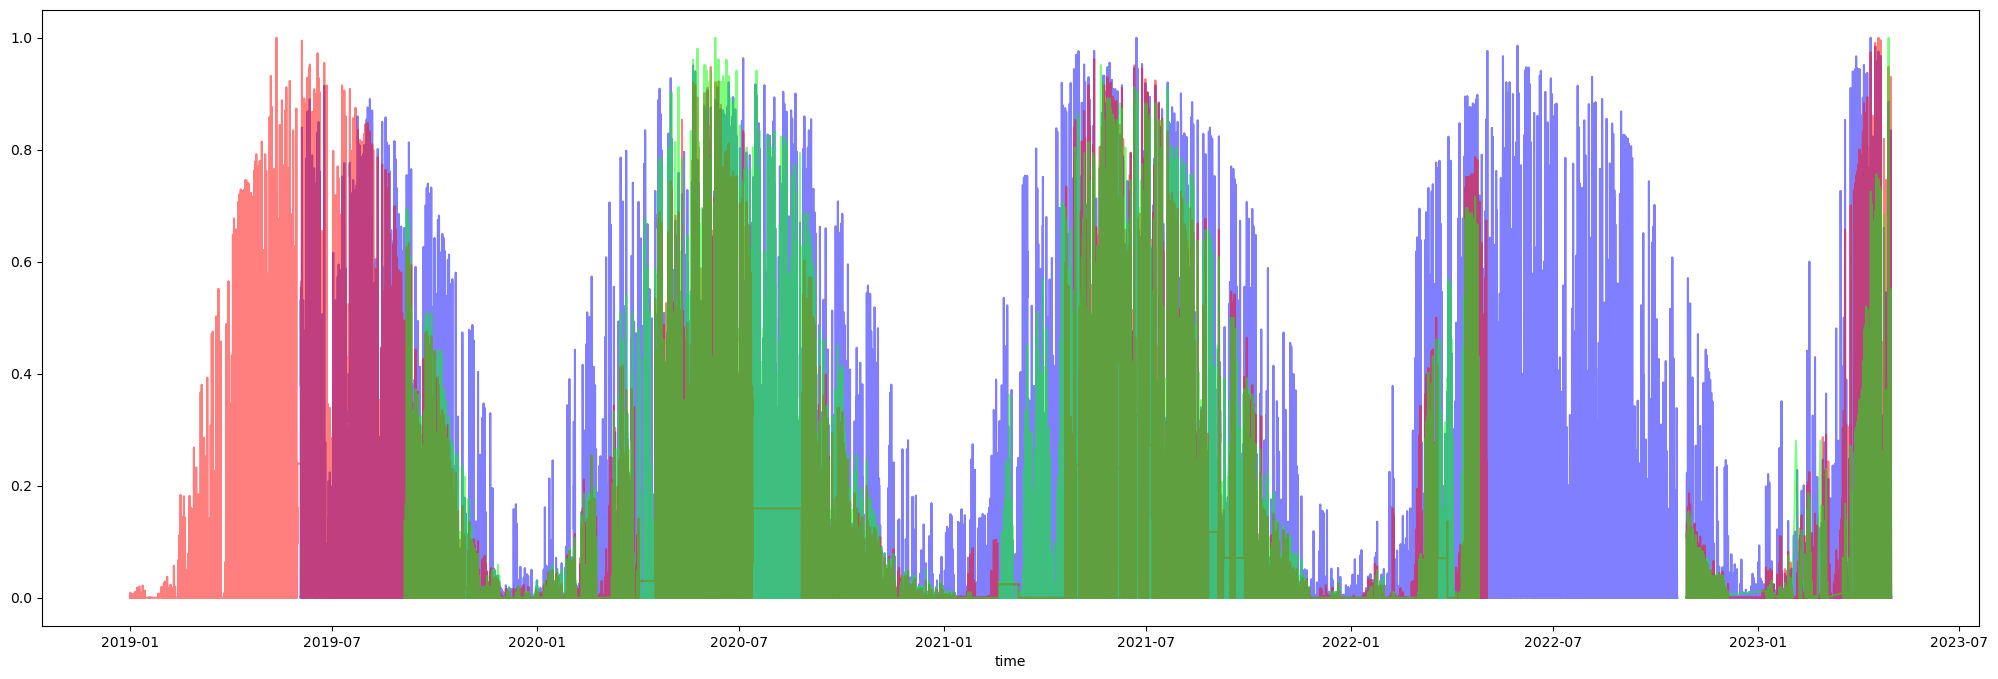

In [6]:
X_a, y_a, _, y2_a = load_train_test('A')
X_b, y_b, _, y2_b = load_train_test('B')
X_c, y_c, _, y2_c = load_train_test('C')

scale1 = MinMaxScaler()

plt.rcParams["figure.figsize"] = [25, 8]

sns.lineplot(x=y_a.index, y=scale1.fit_transform(y_a[["y"]]).T[0], c="blue", alpha=0.5)
sns.lineplot(x=y_b.index, y=scale1.fit_transform(y_b[["y"]]).T[0], c="red", alpha=0.5)
sns.lineplot(x=y_c.index, y=scale1.fit_transform(y_c[["y"]]).T[0], c="lime", alpha=0.5)

sns.lineplot(x=y2_a.index, y=scale1.fit_transform(y2_a[["y"]]).T[0], c="blue", alpha=0.5)
sns.lineplot(x=y2_b.index, y=scale1.fit_transform(y2_b[["y"]]).T[0], c="red", alpha=0.5)
sns.lineplot(x=y2_c.index, y=scale1.fit_transform(y2_c[["y"]]).T[0], c="lime", alpha=0.5)


In [7]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [8]:
features = [
    "absolute_humidity_2m:gm3",
    # "direct_rad:W",
    # "effective_cloud_cover:p",
    "eff_cloud_2h-",
    "precip_5min_2h-",
    # "air_density_2m:kgm3",
    # "clear_sky_energy_1h:J",            # Weird
    "clear_sky_rad:W",
    # "dew_or_rime:idx",
    # "dew_point_2m:K",
    "diffuse_rad:W",
    # "diffuse_rad_1h:J",                   # Weird
    "direct_rad:W",
    # "direct_rad_1h:J",                    # Weird
    "elevation:m",
    "is_day:idx",
    # "is_in_shadow:idx",
    "msl_pressure:hPa",
    # "precip_5min:mm",
    # "precip_type_5min:idx",
    # "pressure_100m:hPa",
    "pressure_50m:hPa",
    # "prob_rime:p",
    "rain_water:kgm2",
    "relative_humidity_1000hPa:p",
    # "sfc_pressure:hPa",
    "sun_azimuth:d",
    "sun_elevation:d",
    # "super_cooled_liquid_water:kgm2",
    "t_1000hPa:K",                        # Temperatur på en viss høydemeter
    # "total_cloud_cover:p",
    "visibility:m",
    # "wind_speed_10m:ms",
    "wind_speed_u_10m:ms",
    # "wind_speed_v_10m:ms",
    # "wind_speed_w_1000hPa:ms",
    "rel_hum_2h-",
    "eff_cloud_temp_1h",
    "hour",
    "dayofmonth",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "A", "B", "C"
]

In [9]:
# features = [
#     "direct_rad:W",
#     "diffuse_rad:W",
#     "precip_5min:mm",
#     "clear_sky_rad:W",
#     "fresh_snow_24h:cm",
#     "sun_azimuth:d",
#     # "effective_cloud_cover:p",
#     "eff_cloud_2h-",
#     "day_of_year",
#     "sun_elevation:d",
#     "year",
#     "sfc_pressure:hPa",
#     "rel_hum_2h-",
#     "pressure_100m:hPa",
#     "temp_2h-",
#     "dew_point_2m:K",
#     # "temp_2h",
#     "temp_1h-",
#     "precip_type_5min:idx",
#     "hour",
#     # "eff_cloud_irrad_1h",
#     "super_cooled_liquid_water:kgm2",
#     # "eff_cloud_1h-",
#     "wind_speed_v_10m:ms",
#     "wind_speed_u_10m:ms",
#     "t_1000hPa:K",
#     "month",
#     "precip_5min_2h",
#     # "total_cloud_cover:p",
#     "visibility:m",
#     # "temp_1h",
#     "day",
#     # "eff_cloud_2h",
#     # "precip_5min_1h",
#     "msl_pressure:hPa",
#     "precip_5min_1h-",
#     "day_of_week",
#     "rel_hum_1h-",
#     "fresh_snow_12h:cm",
#     "eff_cloud_temp_1h",
#     "A", "B", "C"
# ]

In [10]:
def feature_engineering(X: pd.DataFrame):
    # 1. Add time features
    X["time"] = pd.to_datetime(X["time"])
    X["year"] = X["time"].dt.year
    X["month"] = X["time"].dt.month
    X["day"] = X["time"].dt.day
    X["hour"] = X["time"].dt.hour
    X["day_of_week"] = X["time"].dt.dayofweek
    X["day_of_year"] = X["time"].dt.dayofyear
    X["quarter"] = X["time"].dt.quarter
    X["is_weekend"] = X["day_of_week"].isin([5, 6]).astype(int)
    X["is_weekday"] = X["day_of_week"].isin([0, 1, 2, 3, 4]).astype(int)

    # Add lag and ahead features for temperature
    X["temp_1h"] = X["t_1000hPa:K"].shift(1)
    X["temp_2h"] = X["t_1000hPa:K"].shift(2)
    # X["temp_1h-"] = X["t_1000hPa:K"].shift(-1)
    # X["temp_2h-"] = X["t_1000hPa:K"].shift(-2)

    X["rel_hum_1h-"] = X["relative_humidity_1000hPa:p"].shift(-1)
    X["rel_hum_2h-"] = X["relative_humidity_1000hPa:p"].shift(-2)

    # Add lag and ahead features for effective cloud cover
    # X["eff_cloud_1h"] = X["effective_cloud_cover:p"].shift(1)
    # X["eff_cloud_2h"] = X["effective_cloud_cover:p"].shift(2)
    X["eff_cloud_1h-"] = X["effective_cloud_cover:p"].shift(-1)
    X["eff_cloud_2h-"] = X["effective_cloud_cover:p"].shift(-2)

    # Add lag and ahead features for precipitation
    # X["precip_5min_1h"] = X["precip_5min:mm"].shift(1)
    # X["precip_5min_2h"] = X["precip_5min:mm"].shift(2)
    X["precip_5min_1h-"] = X["precip_5min:mm"].shift(-1)
    X["precip_5min_2h-"] = X["precip_5min:mm"].shift(-2)

    # Relationship between effective cloud cover and precipitation
    X["eff_cloud_precip_1h"] = X["eff_cloud_2h-"] * X["precip_5min_2h-"]

    # Relationship between effective cloud cover and sun irradiance
    X["eff_cloud_irrad_1h"] = X["eff_cloud_2h-"] * X["direct_rad:W"]

    # Relationship between effective cloud cover and temperature
    X["eff_cloud_temp_1h"] = X["eff_cloud_2h-"] * X["t_1000hPa:K"]

    # Replace "location" with One hot encoding
    # X = pd.get_dummies(X, columns=["location"], dtype=int)

    # Drop columns containing only NaN values
    X = X.dropna(axis=1, how="all")

    # X = X.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m", "snow_density:kgm3"])

    return X

In [11]:
class DatasetPreparer:
    def __init__(self, n_steps):
        self.X_scaler = MinMaxScaler()
        self.y_scalerA = MinMaxScaler()
        self.y_scalerB = MinMaxScaler()
        self.y_scalerC = MinMaxScaler()
        self.n_steps = n_steps
        self.features = features

    def _is_fit_called(self):
        return (
            hasattr(self.X_scaler, "n_features_in_")
            and hasattr(self.y_scalerA, "n_features_in_")
            and hasattr(self.y_scalerB, "n_features_in_")
            and hasattr(self.y_scalerC, "n_features_in_")
        )

    def _fit_by_location(self, y_df):
        self.y_scalerA = self.y_scalerA.fit(y_df[y_df.location == "A"][["y"]])
        self.y_scalerB = self.y_scalerB.fit(y_df[y_df.location == "B"][["y"]])
        self.y_scalerC = self.y_scalerC.fit(y_df[y_df.location == "C"][["y"]])

    def _scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.transform(
                y_df[y_df.location == "A"][["y"]]
            )
        if "B" in list(y_df.location):
            y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.transform(
                y_df[y_df.location == "B"][["y"]]
            )
        if "C" in list(y_df.location):
            y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.transform(
                y_df[y_df.location == "C"][["y"]]
            )

        return y_df["y"]

    def inverse_scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.inverse_transform(
                y_df[y_df.location == "A"][["y"]]
            )
        if "B" in list(y_df.location):
            y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.inverse_transform(
                y_df[y_df.location == "B"][["y"]]
            )
        if "C" in list(y_df.location):
            y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.inverse_transform(
                y_df[y_df.location == "C"][["y"]]
            )

        return y_df

    def prepare(self, X_df, y_df=None):
        df = X_df.copy()

        # Drop missing column values
        nan_columns = df.columns[df.isna().any()].tolist()
        df = df.drop(columns=nan_columns)

        # One-hot Encoding
        df = df.reset_index().drop(columns="index")
        one_hot = pd.get_dummies(df["location"]).astype(int)

        # Add time based features
        df = create_time_features(df)

        # df = df.drop("location", axis=1)
        df = pd.merge(df, one_hot, left_index=True, right_index=True)

        # Add missing location columns
        for location in ("A", "B", "C"):
            if not location in df.columns:
                df[location] = 0

        # Effective cloud cover transform
        df = feature_engineering(df)
        y_df = y_df.copy()

        # Scaling
        if not self._is_fit_called():
            self._fit_by_location(y_df)
        
        y_as_array = np.array(self._scale_by_location(y_df))
        
        y = []
        X = []


        for location in ("A", "B", "C"):
            temp = df[df["location"] == location][features].copy()
            X_temp = []
            if (temp.empty):
                continue
            
            self.features = temp.columns

            # if not isinstance(y_df, pd.DataFrame):
            #     X_as_array = self.X_scaler.transform(temp)
            #     return X_as_array[2:-2]
            

            # Scaling
            if not self._is_fit_called():
                self.X_scaler = self.X_scaler.fit(temp)

            X_as_array = self.X_scaler.transform(temp)


            # y_location = y_as_array[df.location == location]

            # if self.n_steps == 0:
            #     return X_location[2:-2], y_location[2:-2]

            for i in range(len(X_as_array) - self.n_steps):
                row = X_as_array[i : i + self.n_steps].tolist()
                X_temp.append(row)
                # label = y_location[i + self.n_steps]
                # y.append(label)
            print(np.array(X_temp).shape)
            X.append(X_temp)

        return X, y_as_array

In [12]:
# Simulate Kaggle validation set

vals = load_all_vals()
vals["test"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0, 1)
vals["test2"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0.1, 0.9)

val_dates = pd.DataFrame(columns=["time"], data=load_val_dates())
val_dates.time = pd.to_datetime(val_dates.time)

# Get dates of our validation set, offset in order to get the correct test-set timeframe
test_dates = val_dates.copy()
test_dates = test_dates - pd.DateOffset(days=365)

In [13]:
test_size = 5000
window_size = 2

X_data_train = data[0][(data[0].set_type == "TRAIN")].iloc[:-test_size]
y_data_train = data[1][(data[1].set_type == "TRAIN")].iloc[:-test_size]

X_data_test = data[0][(data[0].set_type == "TRAIN")].iloc[-test_size:]
y_data_test = data[1][(data[1].set_type == "TRAIN")].iloc[-test_size:]
X_data_val = data[0][data[0].time.isin(test_dates.time)]
y_data_val = data[1][data[1].time.isin(test_dates.time)]

X_data_kaggle = val_data[val_data.time.isin(val_dates.time)]

preparer = DatasetPreparer(n_steps=window_size)


X_train, y_train = preparer.prepare(X_data_train, y_data_train)
X_test, y_test = preparer.prepare(X_data_test, y_data_test)
X_val, y_val = preparer.prepare(X_data_val, y_data_val)
# X_kaggle = preparer.prepare(X_data_kaggle, None)

print(
    "TRAIN:",
    # X_train.shape,
    y_train.shape,
    "\nTEST:",
    # X_test.shape,
    y_test.shape,
    "\nVAL:",
    # X_val.shape,
    y_val.shape,
    # "\nKAGGLE:",
    # X_kaggle.shape,
    "\nFEATURES:",
    len(preparer.features),
)

(29623, 2, 29)
(22394, 2, 29)
(13300, 2, 29)
(4998, 2, 29)
(718, 2, 29)
(22, 2, 29)
TRAIN: (65323,) 
TEST: (5000,) 
VAL: (744,) 
FEATURES: 29


In [14]:
X_train

[[[[0.4204203997475441,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.6217981810222515,
    0.6216559292842465,
    0.0,
    0.6335704416921051,
    0.9986829767444427,
    0.46212403256040097,
    0.615254375220692,
    0.581011173677384,
    0.1981004153077023,
    0.5853815864413123,
    0.9621744941872521,
    0.9565217391304348,
    0.03333333333333333,
    1.0,
    0.3333333333333333,
    0.4545454545454545,
    0.0,
    0.41643835616438357,
    0.0,
    0.0,
    0.0],
   [0.4204203997475441,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.610748694380101,
    0.6102980278340073,
    0.022727272573335115,
    0.5860284564575005,
    0.2488927591998563,
    0.4562823180632555,
    0.6305083366437145,
    0.4854562223826975,
    0.2103120792494311,
    0.6620310445297561,
    0.9644435754470176,
    1.0,
    0.03333333333333333,
    1.0,
    0.3333333333333333,
    0.4545454545454545,
    0.0,
    0.41643835616438357,
    0.0,
    0.0,
  

TypeError: list indices must be integers or slices, not tuple

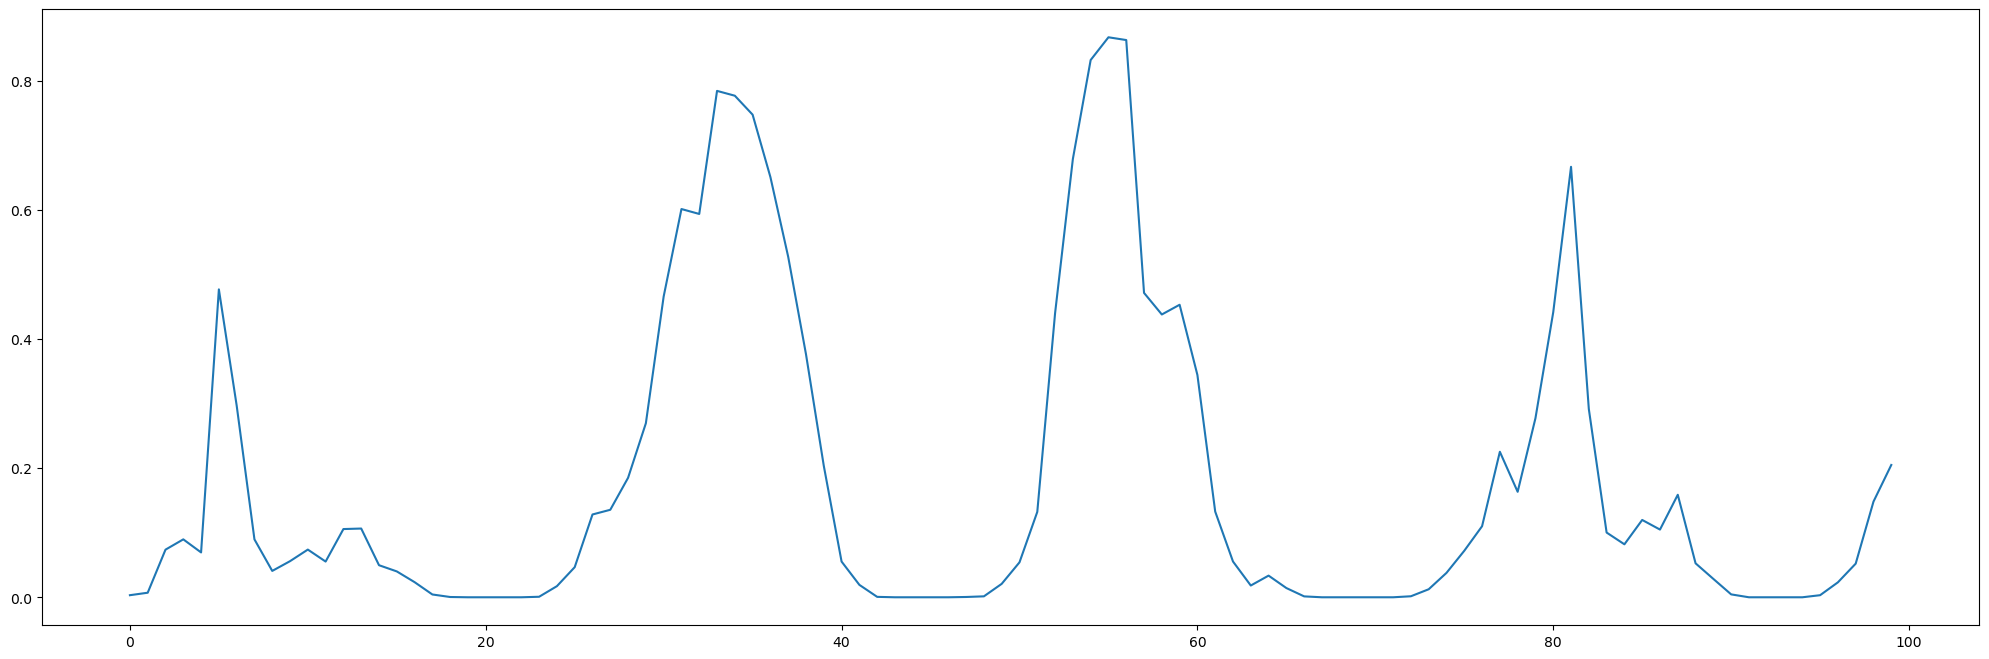

In [15]:
start = 100

plt.plot(y_train[start:100 + start])
plt.plot(X_train[start:100 + start,4] + X_train[start:100 + start,3])
plt.plot(np.maximum(X_train[1 + start:101 + start,1] - 1 + X_train[start:100 + start,2], 0))
# plt.plot(X_train[start:100 + start,2])
# plt.plot(np.maximum(X_train[2 + start:102 + start,1] - X_train[start:100 + start,2] + 1, 1))

In [ ]:
tf.random.set_seed(42)

# LSTM For predicting energy production with 40 features, 1 timestep and 1 output
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(
            128, activation="relu", input_shape=(1, len(preparer.features))
        ),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)
# Define the model
# model_1 = tf.keras.Sequential()

# # Add Convolutional layers
# model_1.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(features) - 3, 1)))
# model_1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model_1.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
# model_1.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# # Flatten the output from Convolutional layers
# model_1.add(tf.keras.layers.Flatten())

# # Add Dense layers for further processing
# # model_1.add(tf.keras.layers.Dense(128, activation='relu'))
# # model_1.add(tf.keras.layers.Dropout(0.2))
# # model_1.add(tf.keras.layers.Dense(64, activation='relu'))

# # Output layer for regression (assuming single-value forecasting)
# model_1.add(tf.keras.layers.Dense(1, activation='linear'))

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=1, verbose=1, factor=0.1
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1, mode="min"
)

sv = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

model_1.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae"],
)

history_1 = model_1.fit(
    np.expand_dims(X_train, axis=-2),
    y_train,
    epochs=20,
    validation_data=(np.expand_dims(X_test, axis=-2), y_test),
    callbacks=[lr, es, sv],
    batch_size=72,
)

Epoch 1/20
897/908 [============================>.] - ETA: 0s - loss: 0.0395 - mae: 0.0395
Epoch 1: val_loss improved from inf to 0.02513, saving model to ./checkpoints


INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


908/908 [==============================] - 4s 3ms/step - loss: 0.0395 - mae: 0.0395 - val_loss: 0.0251 - val_mae: 0.0251 - lr: 0.0010
Epoch 2/20
901/908 [============================>.] - ETA: 0s - loss: 0.0336 - mae: 0.0336
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_loss did not improve from 0.02513
908/908 [==============================] - 2s 2ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0266 - val_mae: 0.0266 - lr: 0.0010
Epoch 3/20
893/908 [============================>.] - ETA: 0s - loss: 0.0318 - mae: 0.0318
Epoch 3: val_loss improved from 0.02513 to 0.02352, saving model to ./checkpoints


INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


908/908 [==============================] - 3s 3ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0235 - val_mae: 0.0235 - lr: 1.0000e-04
Epoch 4/20
887/908 [============================>.] - ETA: 0s - loss: 0.0316 - mae: 0.0316
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 4: val_loss did not improve from 0.02352
908/908 [==============================] - 2s 2ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0237 - val_mae: 0.0237 - lr: 1.0000e-04
Epoch 5/20
900/908 [============================>.] - ETA: 0s - loss: 0.0313 - mae: 0.0313
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 5: val_loss did not improve from 0.02352
908/908 [==============================] - 2s 2ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0236 - val_mae: 0.0236 - lr: 1.0000e-05
Epoch 6/20
892/908 [============================>.] - ETA: 0s - loss: 0.0313 - mae: 0.0313
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.00000011

In [ ]:
model_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 128)               80896     
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 89,217
Trainable params: 89,217
Non-trainable params: 0
_________________________________________________________________


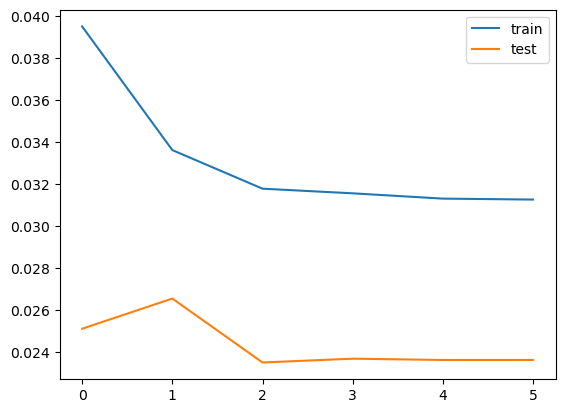

In [ ]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend()
plt.show()


### Test

In [ ]:
n_test = 2200
test_start_id = 0

In [ ]:
model = xgb.XGBRegressor(
    max_depth=9,
    colsample_bytree=0.8,
    eta=0.1,
    n_estimators=90,
    reg_alpha=0.02,
    reg_lambda=0.02
)

model.fit(X_train, y_train)

predictions = model.predict(X_test[test_start_id:test_start_id + n_test])

predictions_df = y_data_test.iloc[test_start_id:test_start_id + n_test].copy()
predictions_df["y"] = predictions
predictions_df = preparer.inverse_scale_by_location(predictions_df).copy()

print(mean_absolute_error(y_train[test_start_id:test_start_id + n_test], predictions))
print(mean_absolute_error(y_data_test.iloc[test_start_id + 2:test_start_id + n_test + 2].y, predictions_df.y))

0.2723875976603574
26.691687711577508


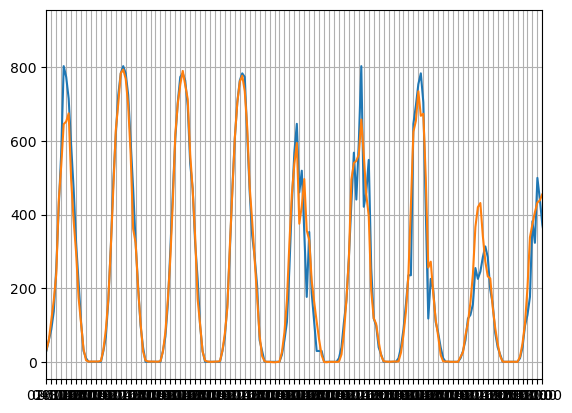

In [ ]:
plt.plot(y_data_test.iloc[test_start_id:test_start_id + n_test].time - pd.DateOffset(hours=2), y_data_test.iloc[test_start_id:test_start_id + n_test].y)
plt.plot(predictions_df.time, predictions_df.y)
plt.xlim(predictions_df.iloc[500].time, predictions_df.iloc[700].time)
plt.grid(True)
plt.gca().xaxis.grid(True, which='minor', linestyle='--')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=2))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


In [ ]:
predictions = model_1.predict(np.expand_dims(X_train[test_start_id:test_start_id + n_test], axis=-2))

predictions_df = y_data_train.iloc[test_start_id:test_start_id + n_test].copy()
predictions_df["y"] = predictions.T[0]
predictions_df = preparer.inverse_scale_by_location(predictions_df).copy()

print(mean_absolute_error(y_train[test_start_id:test_start_id + n_test], predictions))
print(mean_absolute_error(y_data_train.iloc[test_start_id:test_start_id + n_test].y, predictions_df.y))

69/69 [==============================] - 0s 726us/step
0.05666022905264379
586.4477493433076


(18050.333333333332, 18066.583333333332)

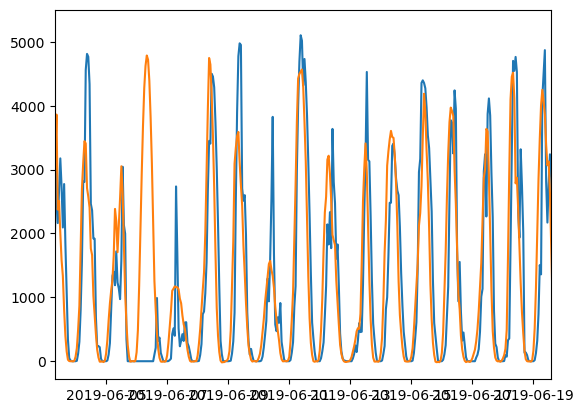

In [ ]:
plt.plot(
    y_data_train[test_start_id:test_start_id + n_test].time,
    y_data_train[test_start_id:test_start_id + n_test].y,
    label="Actual",
)
plt.plot(
    predictions_df.time,
    predictions_df.y,
    label="Prediction",
)
plt.xlim(predictions_df.iloc[10].time, predictions_df.iloc[400].time)


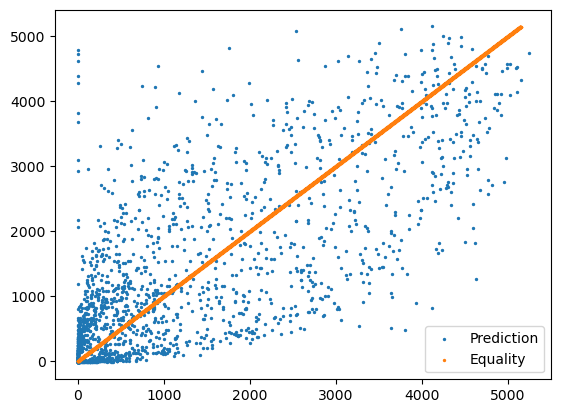

In [ ]:
plt.scatter(y_data_train[test_start_id:test_start_id + n_test].y, predictions_df.y, s=2, label="Prediction")
plt.scatter([i for i in range(int(predictions_df.y.max()))], [i for i in range(int(predictions_df.y.max()))], s=2, label="Equality")
plt.legend()

### Validation

In [ ]:
X_val.shape, y_data_val.shape

((10791, 29), (10795, 4))

In [ ]:
predictions = model_1.predict(np.expand_dims(X_val[6000:], axis=-2))

predictions_df = y_data_val.iloc[6000:].copy()
predictions_df["y"] = predictions.T[0]
predictions_df = preparer.inverse_scale_by_location(predictions_df).copy()

print(mean_absolute_error(y_data_val.iloc[6000:].y, predictions_df.y))

150/150 [==============================] - 0s 736us/step


ValueError: Length of values (4791) does not match length of index (4795)

(19444.958333333332, 19461.625)

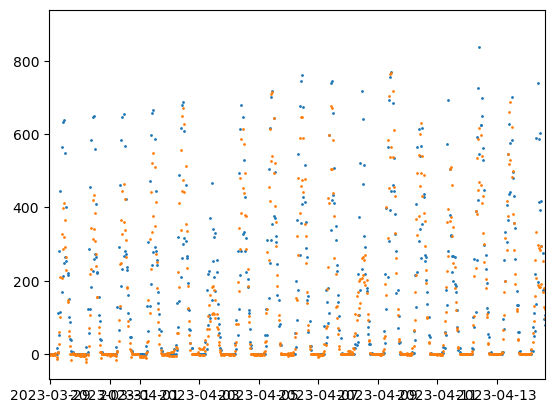

In [ ]:
plt.scatter(
    y_data_val.iloc[6000:].time,
    y_data_val.iloc[6000:].y,
    label="Actual",
    s=1
)
plt.scatter(
    predictions_df.time,
    predictions_df.y,
    label="Prediction",
    s=1
)
plt.xlim(predictions_df.iloc[4000].time, predictions_df.iloc[4400].time)


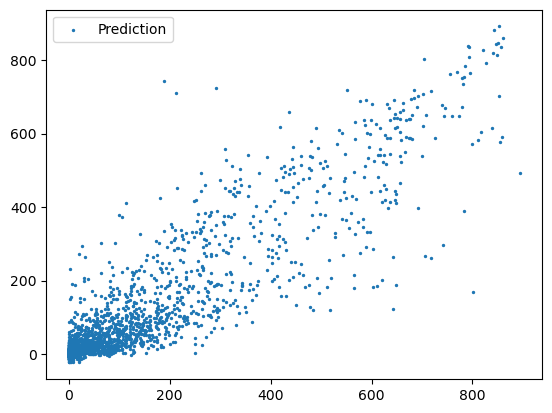

In [ ]:
plt.scatter(y_data_val[6000:].y, predictions_df.y, s=2, label="Prediction")
plt.legend()

### Submission

In [ ]:
predictions = model_1.predict(np.expand_dims(X_kaggle, axis=-2))

68/68 [==============================] - 0s 603us/step


In [ ]:
predictions = model.predict(X_kaggle)

In [ ]:
submission = X_data_kaggle[["location"]].copy()
submission["y"] = np.maximum(predictions, 0)
submission = preparer.inverse_scale_by_location(submission).copy()
submission["prediction"] = submission["y"]
submission = submission.reset_index().drop(columns=["index", "location", "y"])
submission.index.name = "id"
submission.to_csv("submission4.csv")

ValueError: Length of values (2156) does not match length of index (2160)